<a href="https://colab.research.google.com/github/AlbertV100/Spring/blob/main/Sentiment_Wrangling_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# 🧹 Data Wrangling (Final) — TweetEval Sentiment

This notebook implements **production-grade data wrangling** for a sentiment analysis project using the **TweetEval** dataset on Hugging Face. It is aligned to the Capstone **Data Wrangling** rubric and includes:
- **Data Collection** (load + snapshot)
- **Data Organization** (folders, reproducibility)
- **Data Definition** (schema, types, ranges, distributions)
- **Data Cleaning** (NAs, duplicates, robust text cleaning)

> Ready to run in **Google Colab**. If a package is missing, the install cell will handle it.


In [1]:

#@title ✅ Optional: Install/upgrade dependencies (Colab-friendly)
# If running in Colab, you may uncomment the next line.
# !pip -q install -U datasets


In [2]:

# === Reproducibility & Setup ===
RANDOM_SEED = 42

import os, sys, platform, math, re, json, random
random.seed(RANDOM_SEED)

print("Python:", platform.python_version())
print("Executable:", sys.executable)

# Avoid noisy scientific output defaults
import warnings
warnings.filterwarnings("ignore")


Python: 3.12.11
Executable: /usr/bin/python3



## 1) Data Collection

We load the **TweetEval (sentiment)** dataset using Hugging Face `datasets`. We keep data in its native Arrow format for fast, memory-efficient transforms, converting to pandas **only when needed** (e.g., for quick tabular inspection or plotting).


In [3]:

from datasets import load_dataset

# Load the TweetEval sentiment task
ds = load_dataset("tweet_eval", "sentiment")
train_ds = ds["train"]
val_ds   = ds["validation"]
test_ds  = ds["test"]

train_ds, val_ds, test_ds


(Dataset({
     features: ['text', 'label'],
     num_rows: 45615
 }),
 Dataset({
     features: ['text', 'label'],
     num_rows: 2000
 }),
 Dataset({
     features: ['text', 'label'],
     num_rows: 12284
 }))


## 2) Data Organization

- Create a simple project structure for Colab runtime:
```
/content/
  ├── data/
  │   ├── raw/
  │   └── processed/
  └── outputs/
```
- Save a **raw snapshot** (CSV) for traceability.


In [4]:

# Create folders
base_dir = "/content"
data_dir = os.path.join(base_dir, "data")
raw_dir = os.path.join(data_dir, "raw")
proc_dir = os.path.join(data_dir, "processed")
out_dir = os.path.join(base_dir, "outputs")

for d in [data_dir, raw_dir, proc_dir, out_dir]:
    os.makedirs(d, exist_ok=True)

raw_snapshot_path = os.path.join(raw_dir, "tweeteval_train_raw.csv")


In [5]:

# Save a raw snapshot of the training split for traceability
import pandas as pd

train_raw_df = pd.DataFrame(train_ds[:])
train_raw_df.to_csv(raw_snapshot_path, index=False)
print("Raw snapshot saved to:", raw_snapshot_path, "| shape:", train_raw_df.shape)


Raw snapshot saved to: /content/data/raw/tweeteval_train_raw.csv | shape: (45615, 2)



## 3) Data Definition

We examine:
- Column names and data types
- Value ranges and distributions (label counts)
- A few random examples


In [6]:

# Column names, dtypes (via pandas for convenience)
print("Columns:", train_raw_df.columns.tolist())
print("\nData types:")
print(train_raw_df.dtypes)

# Label distribution (train)
label_counts = train_raw_df["label"].value_counts().sort_index()
label_probs  = (label_counts / label_counts.sum()).round(4)
print("\nLabel counts (train):\n", label_counts.to_string())
print("\nLabel proportions (train):\n", label_probs.to_string())

# Peek at examples
print("\nSample texts:")
for i, row in train_raw_df.sample(3, random_state=42).iterrows():
    print(f"- label={row['label']} | text={row['text'][:160]!r}")


Columns: ['text', 'label']

Data types:
text     object
label     int64
dtype: object

Label counts (train):
 label
0     7093
1    20673
2    17849

Label proportions (train):
 label
0    0.1555
1    0.4532
2    0.3913

Sample texts:
- label=0 | text='I forgot all about Ice Cube being in the movie First Sunday. I think I seen this shit in the theaters.'
- label=1 | text='playoffs are finally set. Chardon plays warren howland in the 1st round. if we win\\u002c we play the winner of kenston v. tallmadge.'
- label=1 | text='Are we just going to ignore the fact that Ice Cube got his ass whoop by Ricky Smiley at the beginning of Friday After Next???'



## 4) Data Cleaning

We will:
1. **Log initial shape**
2. **Assess missing values**
3. **Drop rows with null/empty `text` or `label`**
4. **Drop duplicate texts**
5. **Normalize text** (lowercase, strip URLs/mentions/hashtags/punct/digits)
6. **Map numeric labels** → `negative`/`neutral`/`positive`
7. **Log final shape**


In [7]:

# Initial shape
init_shape = train_raw_df.shape
print("Initial shape (rows, cols):", init_shape)

# Missing values report
mv = train_raw_df.isnull().sum().sort_values(ascending=False)
print("\nMissing values per column:\n", mv.to_string())


Initial shape (rows, cols): (45615, 2)

Missing values per column:
 text     0
label    0


In [8]:

# Drop NA for critical columns
clean_df = train_raw_df.dropna(subset=["text", "label"]).copy()

# Drop duplicate texts (keep first instance)
before_dups = clean_df.shape[0]
clean_df = clean_df.drop_duplicates(subset=["text"])
after_dups = clean_df.shape[0]
print(f"Dropped duplicates: {before_dups - after_dups}")


Dropped duplicates: 29


In [9]:

# Robust tweet cleaning
def clean_tweet(text: str) -> str:
    t = text.lower()
    t = re.sub(r"http\S+|www\S+", "", t)   # URLs
    t = re.sub(r"@\w+|#\w+", "", t)        # mentions & hashtags (remove handles/hashtags)
    t = re.sub(r"[^\w\s]", "", t)          # punctuation/symbols
    t = re.sub(r"\d+", "", t)               # digits
    t = re.sub(r"\s+", " ", t)              # squeeze whitespace
    return t.strip()

clean_df["clean_text"] = clean_df["text"].apply(clean_tweet)


In [10]:

# Map labels to human-readable classes
label_map = {0: "negative", 1: "neutral", 2: "positive"}
clean_df["sentiment"] = clean_df["label"].map(label_map)

# Remove any rows that became empty after cleaning
before_empty = clean_df.shape[0]
clean_df = clean_df[clean_df["clean_text"].str.len() > 0].copy()
after_empty = clean_df.shape[0]
print(f"Dropped empty-after-cleaning rows: {before_empty - after_empty}")

# Final shape
final_shape = clean_df.shape
print("Final shape (rows, cols):", final_shape)


Dropped empty-after-cleaning rows: 1
Final shape (rows, cols): (45585, 4)



### 4.1 Label Distribution (Post-Cleaning)


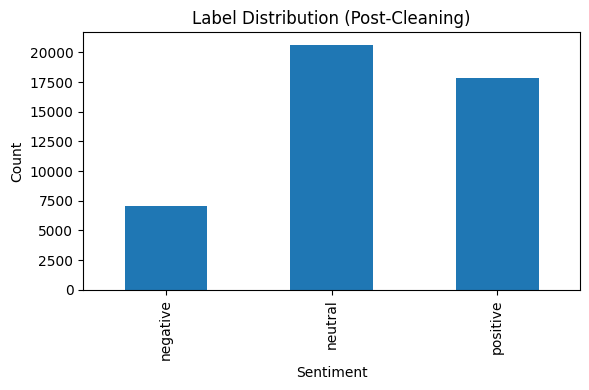

In [11]:

# Plot with matplotlib (Colab-friendly, no styling assumptions)
import matplotlib.pyplot as plt

counts = clean_df["sentiment"].value_counts().reindex(["negative","neutral","positive"])
plt.figure(figsize=(6,4))
counts.plot(kind="bar")
plt.title("Label Distribution (Post-Cleaning)")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.tight_layout()
plt.show()



## 5) Save Processed Output

We persist a **processed CSV** for downstream modeling (TF‑IDF, classical ML, or LLM baselines).



## ✅ Rubric Alignment - Rundown

**Data Collection** — Loaded TweetEval via `datasets` and saved a raw snapshot for traceability.  
**Data Organization** — Created `data/raw`, `data/processed`, and `outputs` directories; reproducibility seed.  
**Data Definition** — Reported columns, dtypes, label counts/proportions, and examples.  
**Data Cleaning** — Addressed missing values, duplicates, normalization of text, label mapping, and verified final shape; plotted class distribution.

> Next step: vectorization (TF‑IDF), train/validation split strategy, and classifier baselines.


In [12]:

processed_path = os.path.join(proc_dir, "tweeteval_train_processed.csv")
cols_to_save = ["text", "clean_text", "label", "sentiment"]
clean_df.to_csv(processed_path, index=False, columns=cols_to_save)
print("Processed CSV saved to:", processed_path, "| shape:", clean_df.shape)


Processed CSV saved to: /content/data/processed/tweeteval_train_processed.csv | shape: (45585, 4)
